## **Introduction**

In [ ]:
# Import Statements

import pandas as pd
import numpy as np
import string

from sklearn.model_selection import train_test_split, cross_val_score

from gensim.models import Word2Vec
from sklearn.decomposition import PCA

from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.ensemble import RandomForestClassifier

from sklearn.neighbors import KNeighborsClassifier

import xgboost as xgb
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, classification_report

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

from imblearn.over_sampling import SMOTE

In [ ]:
# Read the VADER dataset

vader_data = pd.read_csv('/content/coffee_VADER_sentiment_analysis_results.csv')

## **Exploratory Data Analysis**

In [ ]:
# Get the rating range.

rating_min = vader_data['rating'].min()
rating_max = vader_data['rating'].max()

print(f'The ratings range from {rating_min} to {rating_max}.')

The ratings range from 84 to 98.


In [ ]:
# Create rating buckets.

vader_data['rating_bucket'] = pd.cut(vader_data['rating'], bins = [83, 89, 94, 98], labels = ['Low Rating', 'Medium Rating', 'High Rating'])

print('Rating Bucket Metrics:\n')
vader_data['rating_bucket'].value_counts()

Rating Bucket Metrics:



,count
rating_bucket,
Medium Rating,1723
High Rating,339
Low Rating,33


In [ ]:
# Get the price range.

price_min = vader_data['100g_USD'].min()
price_max = vader_data['100g_USD'].max()

print(f'The prices range from ${price_min:.2f} to ${price_max:.2f}.')

The prices range from $0.12 to $132.28.


In [ ]:
# Get price metrics.

vader_data['price_bucket'] = pd.cut(vader_data['100g_USD'], bins = [0,10,20,30,100], labels = ['Low Price', 'Medium_Price', 'High Price', 'Very High Price'])

print('Price metrics:\n')
vader_data['100g_USD'].value_counts()

Price metrics:



,count
100g_USD,
5.29,119
5.88,77
5.58,74
4.70,51
4.41,48
...,...
4.36,1
6.66,1
35.19,1


In [ ]:
# Get sentiment score (scaled 1-10) metrics.

print('Sentiment Score (scaled 1-10) metrics:\n')
vader_data['compound_scaled_1_10'].describe()

Sentiment Score (scaled 1-10) metrics:



,compound_scaled_1_10
count,2095.000000
mean,8.868403
std,0.881559
min,4.589650
25%,8.691625
50%,9.156700
75%,9.474850
max,9.887500


In [ ]:
# Create 3 buckets for the sentiment scores.

vader_data['sentiment_bucket'] = pd.cut(vader_data['compound_scaled_1_10'], bins = [0,4,7,10], labels = ['Low Sentiment', 'Neutral Sentiment', 'High Sentiment'])
vader_data['sentiment_bucket'].value_counts()

,count
sentiment_bucket,
High Sentiment,2011
Neutral Sentiment,84
Low Sentiment,0


In [ ]:
# Take a quick look at the dataset.

vader_data.head()

,name,roaster,roast,loc_country,origin_1,origin_2,100g_USD,rating,review_date,desc_1,cleaned_desc_1,sentiment_scores,compound,compound_scaled_0_1,compound_scaled_1_10,rating_bucket,price_bucket,sentiment_bucket
0,“Sweety” Espresso Blend,A.R.C.,Medium_Light,Hong Kong,Panama,Ethiopia,14.32,95,2017-11-01,"Evaluated as espresso. Sweet-toned, deeply ric...",evaluated espresso sweettoned deeply rich choc...,"{'neg': 0.0, 'neu': 0.84, 'pos': 0.16, 'compou...",0.8310,0.91550,9.23950,High Rating,Medium_Price,High Sentiment
1,Flora Blend Espresso,A.R.C.,Medium_Light,Hong Kong,Africa,Asia Pacific,9.05,94,2017-11-01,"Evaluated as espresso. Sweetly tart, floral-to...",evaluated espresso sweetly tart floraltoned ho...,"{'neg': 0.0, 'neu': 0.711, 'pos': 0.289, 'comp...",0.9217,0.96085,9.64765,Medium Rating,Low Price,High Sentiment
2,Ethiopia Shakiso Mormora,Revel Coffee,Medium_Light,United States,Guji Zone,Southern Ethiopia,4.70,92,2017-11-01,"Crisply sweet, cocoa-toned. Lemon blossom, roa...",crisply sweet cocoatoned lemon blossom roasted...,"{'neg': 0.0, 'neu': 0.754, 'pos': 0.246, 'comp...",0.8442,0.92210,9.29890,Medium Rating,Low Price,High Sentiment
3,Ethiopia Suke Quto,Roast House,Medium_Light,United States,Guji Zone,Oromia Region,4.19,92,2017-11-01,"Delicate, sweetly spice-toned. Pink peppercorn...",delicate sweetly spicetoned pink peppercorn da...,"{'neg': 0.0, 'neu': 0.787, 'pos': 0.213, 'comp...",0.7430,0.87150,8.84350,Medium Rating,Low Price,High Sentiment
4,Ethiopia Gedeb Halo Beriti,Big Creek Coffee Roasters,Medium,United States,Gedeb District,Gedeo Zone,4.85,94,2017-11-01,"Deeply sweet, subtly pungent. Honey, pear, tan...",deeply sweet subtly pungent honey pear tangeri...,"{'neg': 0.0, 'neu': 0.79, 'pos': 0.21, 'compou...",0.8169,0.90845,9.17605,Medium Rating,Low Price,High Sentiment


## **Initial Preprocessing & Further Exploratory Data Analysis**

In [ ]:
# Convert the review date field's type to datetime, and then segment it into 3 fields to cover the year, month, & day.

vader_data['review_date'] = pd.to_datetime(vader_data['review_date'])

vader_data['review_year'] = vader_data['review_date'].dt.year
vader_data['review_month'] = vader_data['review_date'].dt.month
vader_data['review_day'] = vader_data['review_date'].dt.day

In [ ]:
# Drop unnecessary columns & create a copy of the dataset to create visualizations with.

vader_data = vader_data.drop(columns = ['desc_1', 'sentiment_scores', 'compound', 'compound_scaled_0_1', 'review_date'])

vader_copy = vader_data.copy()

In [ ]:
# Sort roasters by their average rating & take a look at the top 10.

roaster_ratings = vader_copy.groupby('roaster')['rating'].mean().reset_index().sort_values(by = 'rating', ascending = False)
print('The Roasters, sorted by their average rating:')
roaster_ratings.head(10)

The Roasters, sorted by their average rating:


,roaster,rating
211,Kakalove Café,96.000
162,Genesis Coffee Lab,95.500
75,Campos Coffee,95.500
191,Hula Daddy Kona Coffee,95.125
307,RD Cafe,95.000
375,Taster’s Coffee,95.000
145,Felala Coffee Lab,95.000
350,Small Eyes Café,95.000
50,Boon Boona Coffee,95.000
338,San Francisco Bay Coffee Company,95.000


In [ ]:
# Sort roasters by their average sentiment score & take a look at the top 10.

roaster_sentiment = vader_copy.groupby('roaster')['compound_scaled_1_10'].mean().reset_index().sort_values(by = 'compound_scaled_1_10', ascending = False)
print('The Roasters, sorted by their average sentiment score:')
roaster_sentiment.head(10)

The Roasters, sorted by their average sentiment score:


,roaster,compound_scaled_1_10
268,Novo Coffee,9.88750
297,Portrait Coffee,9.81010
369,Sweet Bloom Coffee Roasters,9.80965
352,South Slope Coffee Roasters,9.80155
59,Cafe Arles,9.77905
10,Aether Coffee,9.75700
147,Fieldheads Coffee Roasting,9.74890
330,Rubasse Coffee Roaster,9.72685
196,JYL Cafe,9.72190
112,Detour Coffee Roasters,9.72145


In [ ]:
# Combine the average ratings & sentiment scores to get the top 10 roasters, sorted by both rating & sentiment.

best_roasters = pd.merge(roaster_ratings, roaster_sentiment, on = 'roaster')
best_roasters.columns = ['roaster', 'avg_rating', 'avg_sentiment']
best_roasters = best_roasters.sort_values(by = ['avg_rating', 'avg_sentiment'], ascending = False)

print("The Top Roasters by both Rating & Sentiment:")
best_roasters.head(10)

The Top Roasters by both Rating & Sentiment:


,roaster,avg_rating,avg_sentiment
0,Kakalove Café,96.000,9.472600
2,Campos Coffee,95.500,9.247375
1,Genesis Coffee Lab,95.500,8.929000
3,Hula Daddy Kona Coffee,95.125,8.817288
18,JYL Cafe,95.000,9.721900
6,Felala Coffee Lab,95.000,9.696250
15,Per’la Specialty Roasters,95.000,9.672400
8,Boon Boona Coffee,95.000,9.608050
19,Good Folks Coffee,95.000,9.482050
7,Small Eyes Café,95.000,9.463150


## **Data Visualization & Roast Summary**

In [ ]:
# Create a fun custom palette for the visualizations!

custom_palette = ['#C8102E', 'springgreen', 'dodgerblue', 'magenta', '#FF8200']

<ipython-input-64-81d4b64caa5c>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(data = vader_copy, x = 'roast', y = 'rating', palette = custom_palette, hue = None)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pas

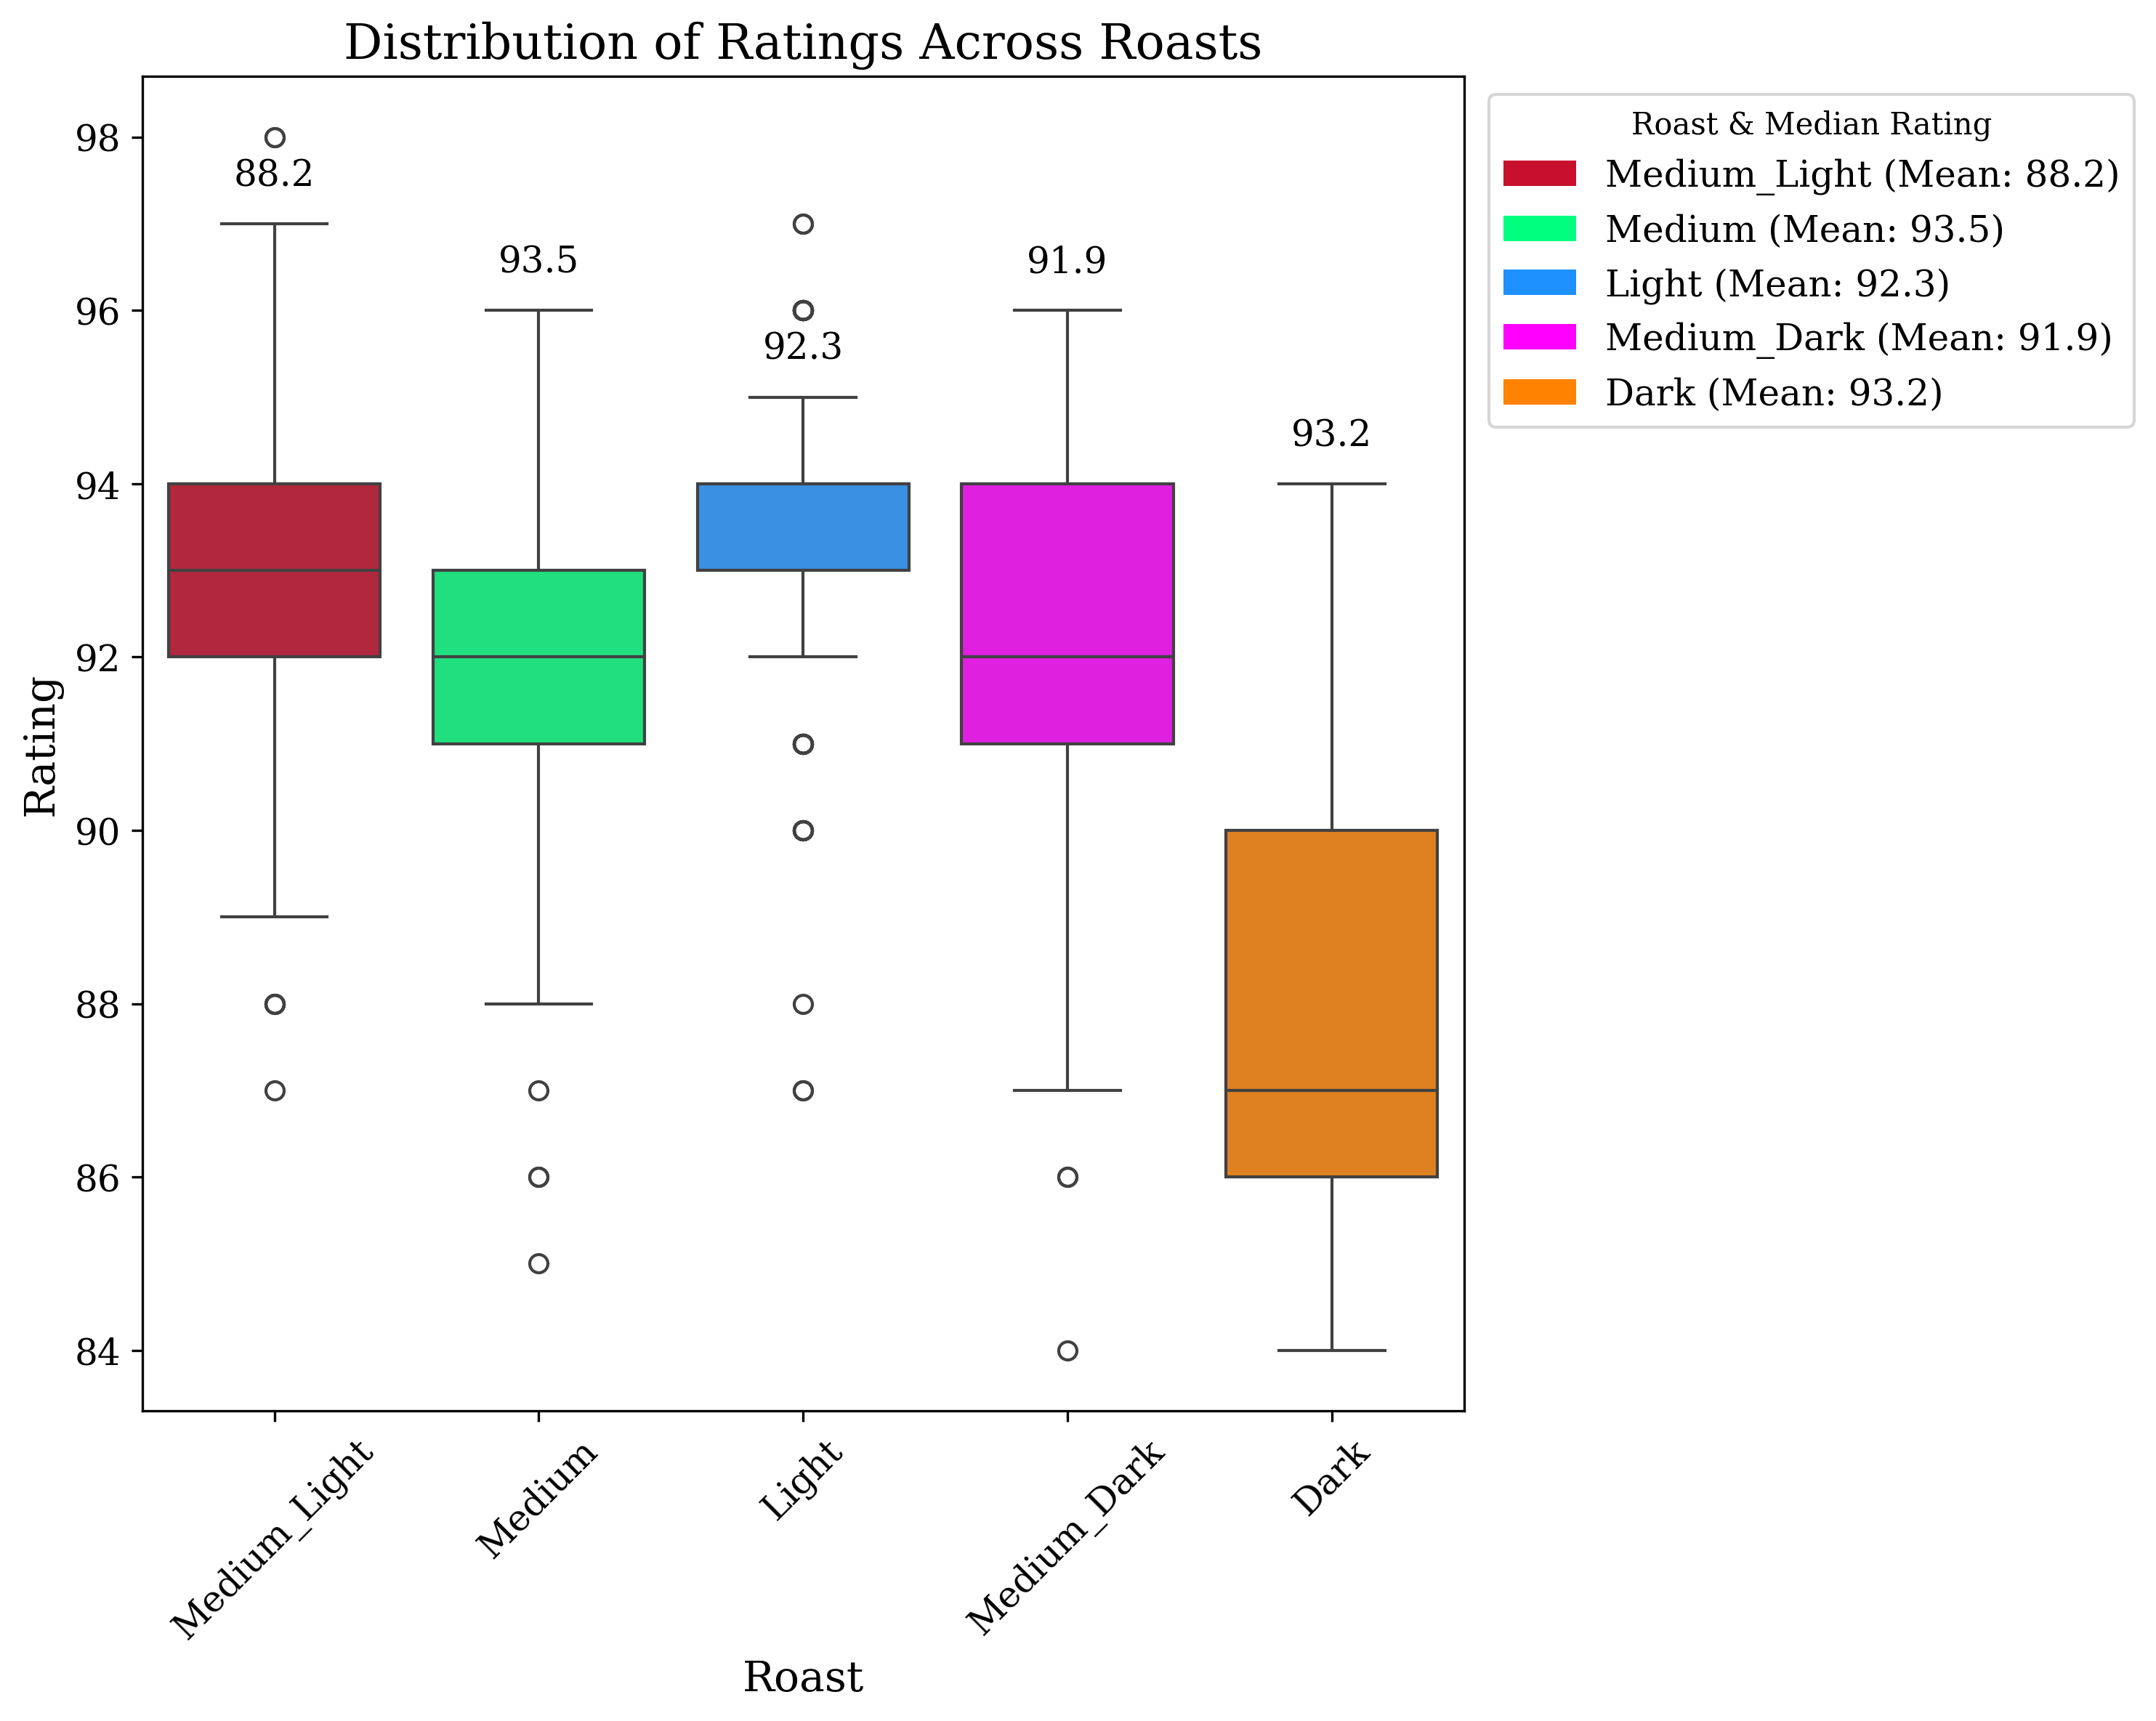

In [ ]:
# Set the default font to serif; it looks better than the standard sans-serif we see anywhere!
plt.rcParams['font.family'] = 'serif'

# Set the figure size & dots per inch to make the chart look sharp!
plt.figure(figsize = (10, 8), dpi = 300)

# Create a box plot that shows how ratings are distributed across different roast types.
ax = sns.boxplot(data = vader_copy, x = 'roast', y = 'rating', palette = custom_palette, hue = None)


# Annotate the box plot so that we can see the mean rating values.

rating_means = vader_copy.groupby(['roast'])['rating'].mean().values

for i, mean in enumerate(rating_means):
  upper_whisker = ax.lines[1 + i * 6].get_ydata()[1]
  ax.annotate(f'{mean:.1f}', xy = (i, upper_whisker),
              xytext = (0,10), textcoords = 'offset points',
              ha = 'center', va = 'bottom', fontsize = 12)

# Create a custom legend to show the roast types, as well as their respective median ratings.

legend_labels = [f'{label} (Mean: {mean:.1f})' for label, mean in zip(['Medium_Light', 'Medium', 'Light', 'Medium_Dark', 'Dark'], rating_means)]

# Add the legend & a title to the plot.

legend_colors = custom_palette

handles = [Patch(facecolor = color, label = label) for color, label in zip(legend_colors, legend_labels)]

plt.legend(handles = handles, title = 'Roast & Median Rating', loc = 'upper left', bbox_to_anchor = (1.005, 1), fontsize = 12)

# Set the title & labels, and adjust the x-axis's ticks to make the chart more readable.
plt.title('Distribution of Ratings Across Roasts', fontsize = 16)
plt.xlabel('Roast', fontsize = 14)
plt.ylabel('Rating', fontsize = 14)
plt.xticks(rotation = 45, fontsize = 12)
plt.yticks(fontsize = 12)

# Set the layout so that the chart fits within the figure size we defined and then show the chart.
plt.tight_layout()
plt.show()

<ipython-input-65-c1bce9ae35c1>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.violinplot(data = vader_copy, x = 'roast', y = 'compound_scaled_1_10', palette = custom_palette)


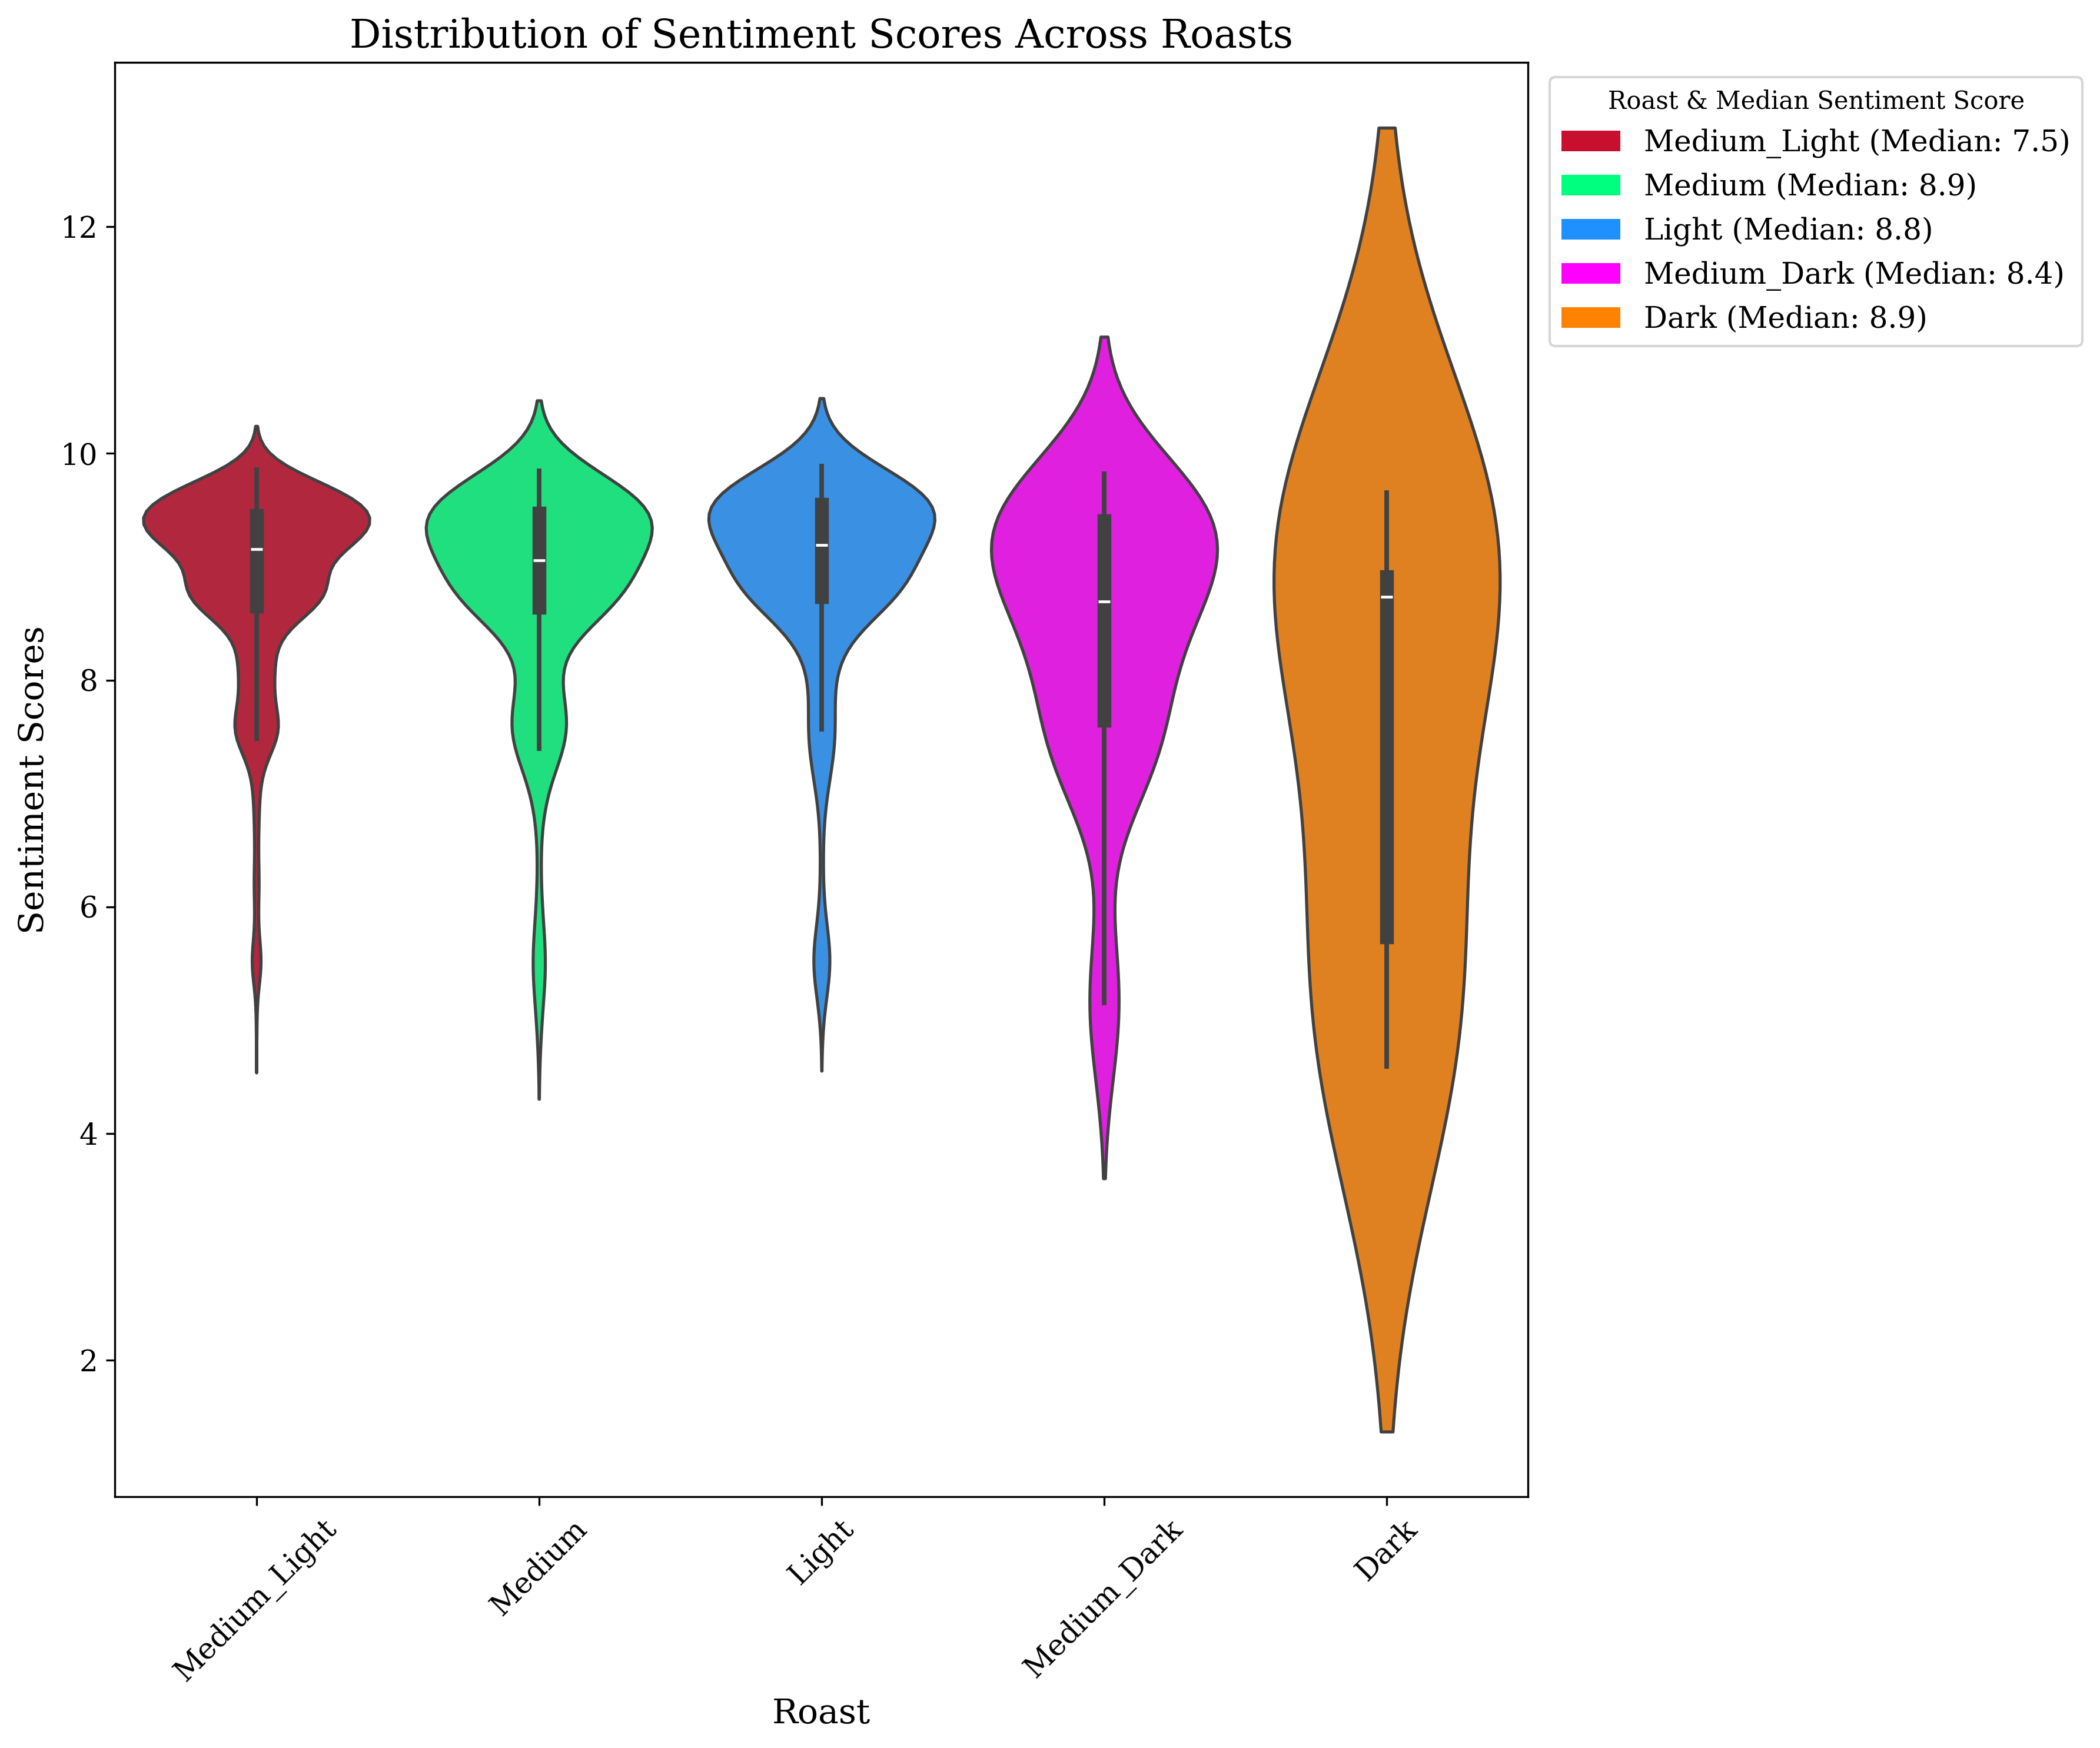

In [ ]:
# Set the default font to serif; it looks better than the standard sans-serif we see anywhere!
plt.rcParams['font.family'] = 'serif'

# Set the figure size & dots per inch to make the chart look sharp!
plt.figure(figsize = (12, 10), dpi = 300)

# Create a box plot that shows how sentiment scores are distributed across different roast types.
ax = sns.violinplot(data = vader_copy, x = 'roast', y = 'compound_scaled_1_10', palette = custom_palette)

# Calculate the median sentiment scores for each roast type.
sentiment_means = vader_copy.groupby(['roast'])['compound_scaled_1_10'].mean().values


legend_labels = [f'{label} (Mean: {mean:.1f})' for label, mean in zip(['Medium_Light', 'Medium', 'Light', 'Medium_Dark', 'Dark'], sentiment_means)]


legend_colors = custom_palette

handles = [Patch(facecolor = color, label = label) for color, label in zip(legend_colors, legend_labels)]

plt.legend(handles = handles, title = 'Roast & Mean Sentiment Score', loc = 'upper left', bbox_to_anchor = (1.005, 1), fontsize = 12)


# Define the legend labels and combine the roast names with the median sentiment scores.
legend_labels = [f'{label} (Median: {median:.1f})' for label, median in zip(['Medium_Light', 'Medium', 'Light', 'Medium_Dark', 'Dark'], sentiment_means)]

legend_colors = custom_palette

# Create a custom legend with the roast names & the corresponding mean values.
handles = [Patch(facecolor = color, label = label) for color, label in zip(legend_colors, legend_labels)]

# Display the legend.
plt.legend(handles = handles, title = 'Roast & Median Sentiment Score', loc = 'upper left', bbox_to_anchor = (1.005, 1), fontsize = 12)

# Set the title & labels, and adjust the x-axis's ticks to make the chart more readable.
plt.title('Distribution of Sentiment Scores Across Roasts', fontsize = 16)
plt.xlabel('Roast', fontsize = 14)
plt.ylabel('Sentiment Scores', fontsize = 14)
plt.xticks(rotation = 45, fontsize = 12)
plt.yticks(fontsize = 12)

# Set the layout so that the chart fits within the figure size we defined and then show the chart.
plt.tight_layout()
plt.show()

<ipython-input-66-51d670912f76>:8: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(data = vader_copy, x = 'roast', y = 'rating', palette = custom_palette, estimator = np.mean, ci = None)
<ipython-input-66-51d670912f76>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data = vader_copy, x = 'roast', y = 'rating', palette = custom_palette, estimator = np.mean, ci = None)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a leng

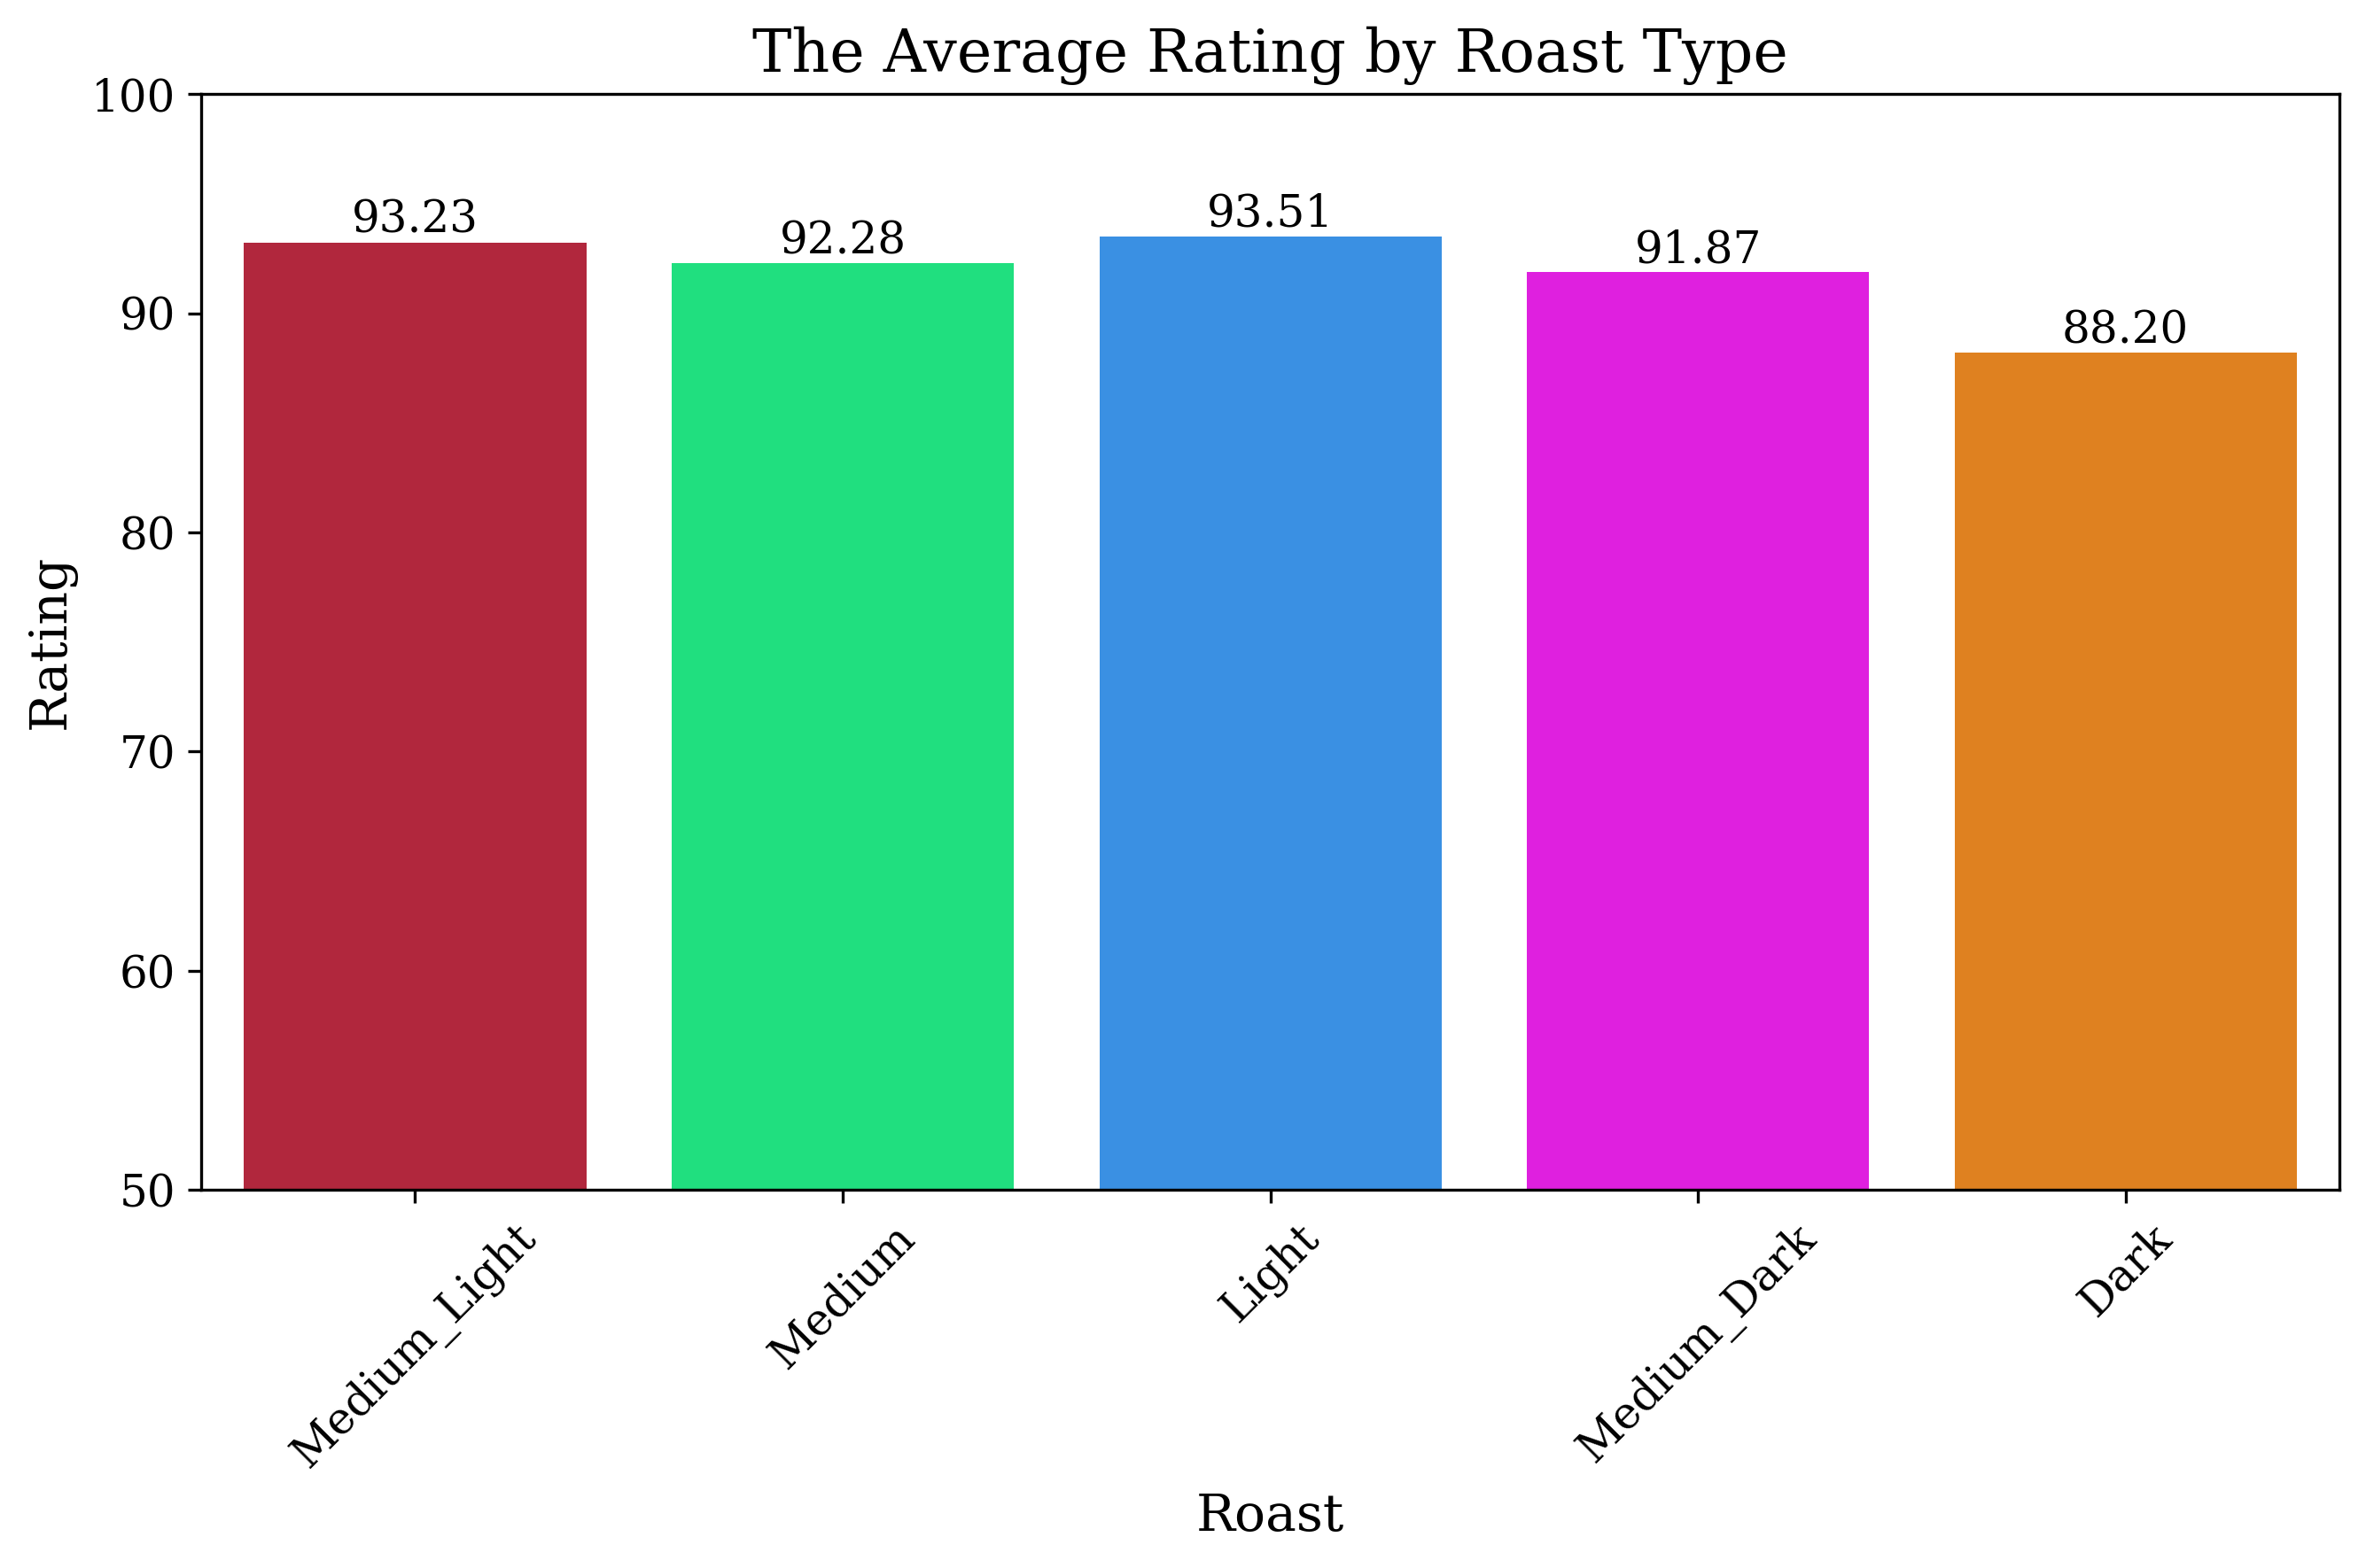

In [ ]:
# Set the default font to serif; it looks better than the standard sans-serif we see anywhere!
plt.rcParams['font.family'] = 'serif'

# Set the figure size & dots per inch to make the chart look sharp!
plt.figure(figsize = (9, 6), dpi = 300)

# Create a bar plot that shows the average rating for each roast type.
ax = sns.barplot(data = vader_copy, x = 'roast', y = 'rating', palette = custom_palette, estimator = np.mean, ci = None)

ax.set_ylim(50,100)

# Associate each bar with the average rating values.
for p in ax.patches:
  ax.text(p.get_x() + p.get_width()/2,
          p.get_height(),
          f'{p.get_height():.2f}',
          ha = 'center', va = 'bottom',
          fontsize = 12)

# Set the title & labels, and adjust the x-axis's ticks to make the chart more readable.
plt.title('The Average Rating by Roast Type', fontsize = 16)
plt.xlabel('Roast', fontsize = 14)
plt.ylabel('Rating', fontsize = 14)
plt.xticks(rotation = 45, fontsize = 12)
plt.yticks(fontsize = 12)

# Set the layout so that the chart fits within the figure size we defined and then show the chart.
plt.tight_layout()
plt.show()

<ipython-input-67-467d3d8a5648>:8: UserWarning: The palette list has more values (5) than needed (4), which may not be intended.
  ax = sns.countplot(data = vader_copy, x = 'roast', hue = 'price_bucket', palette = custom_palette)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple t

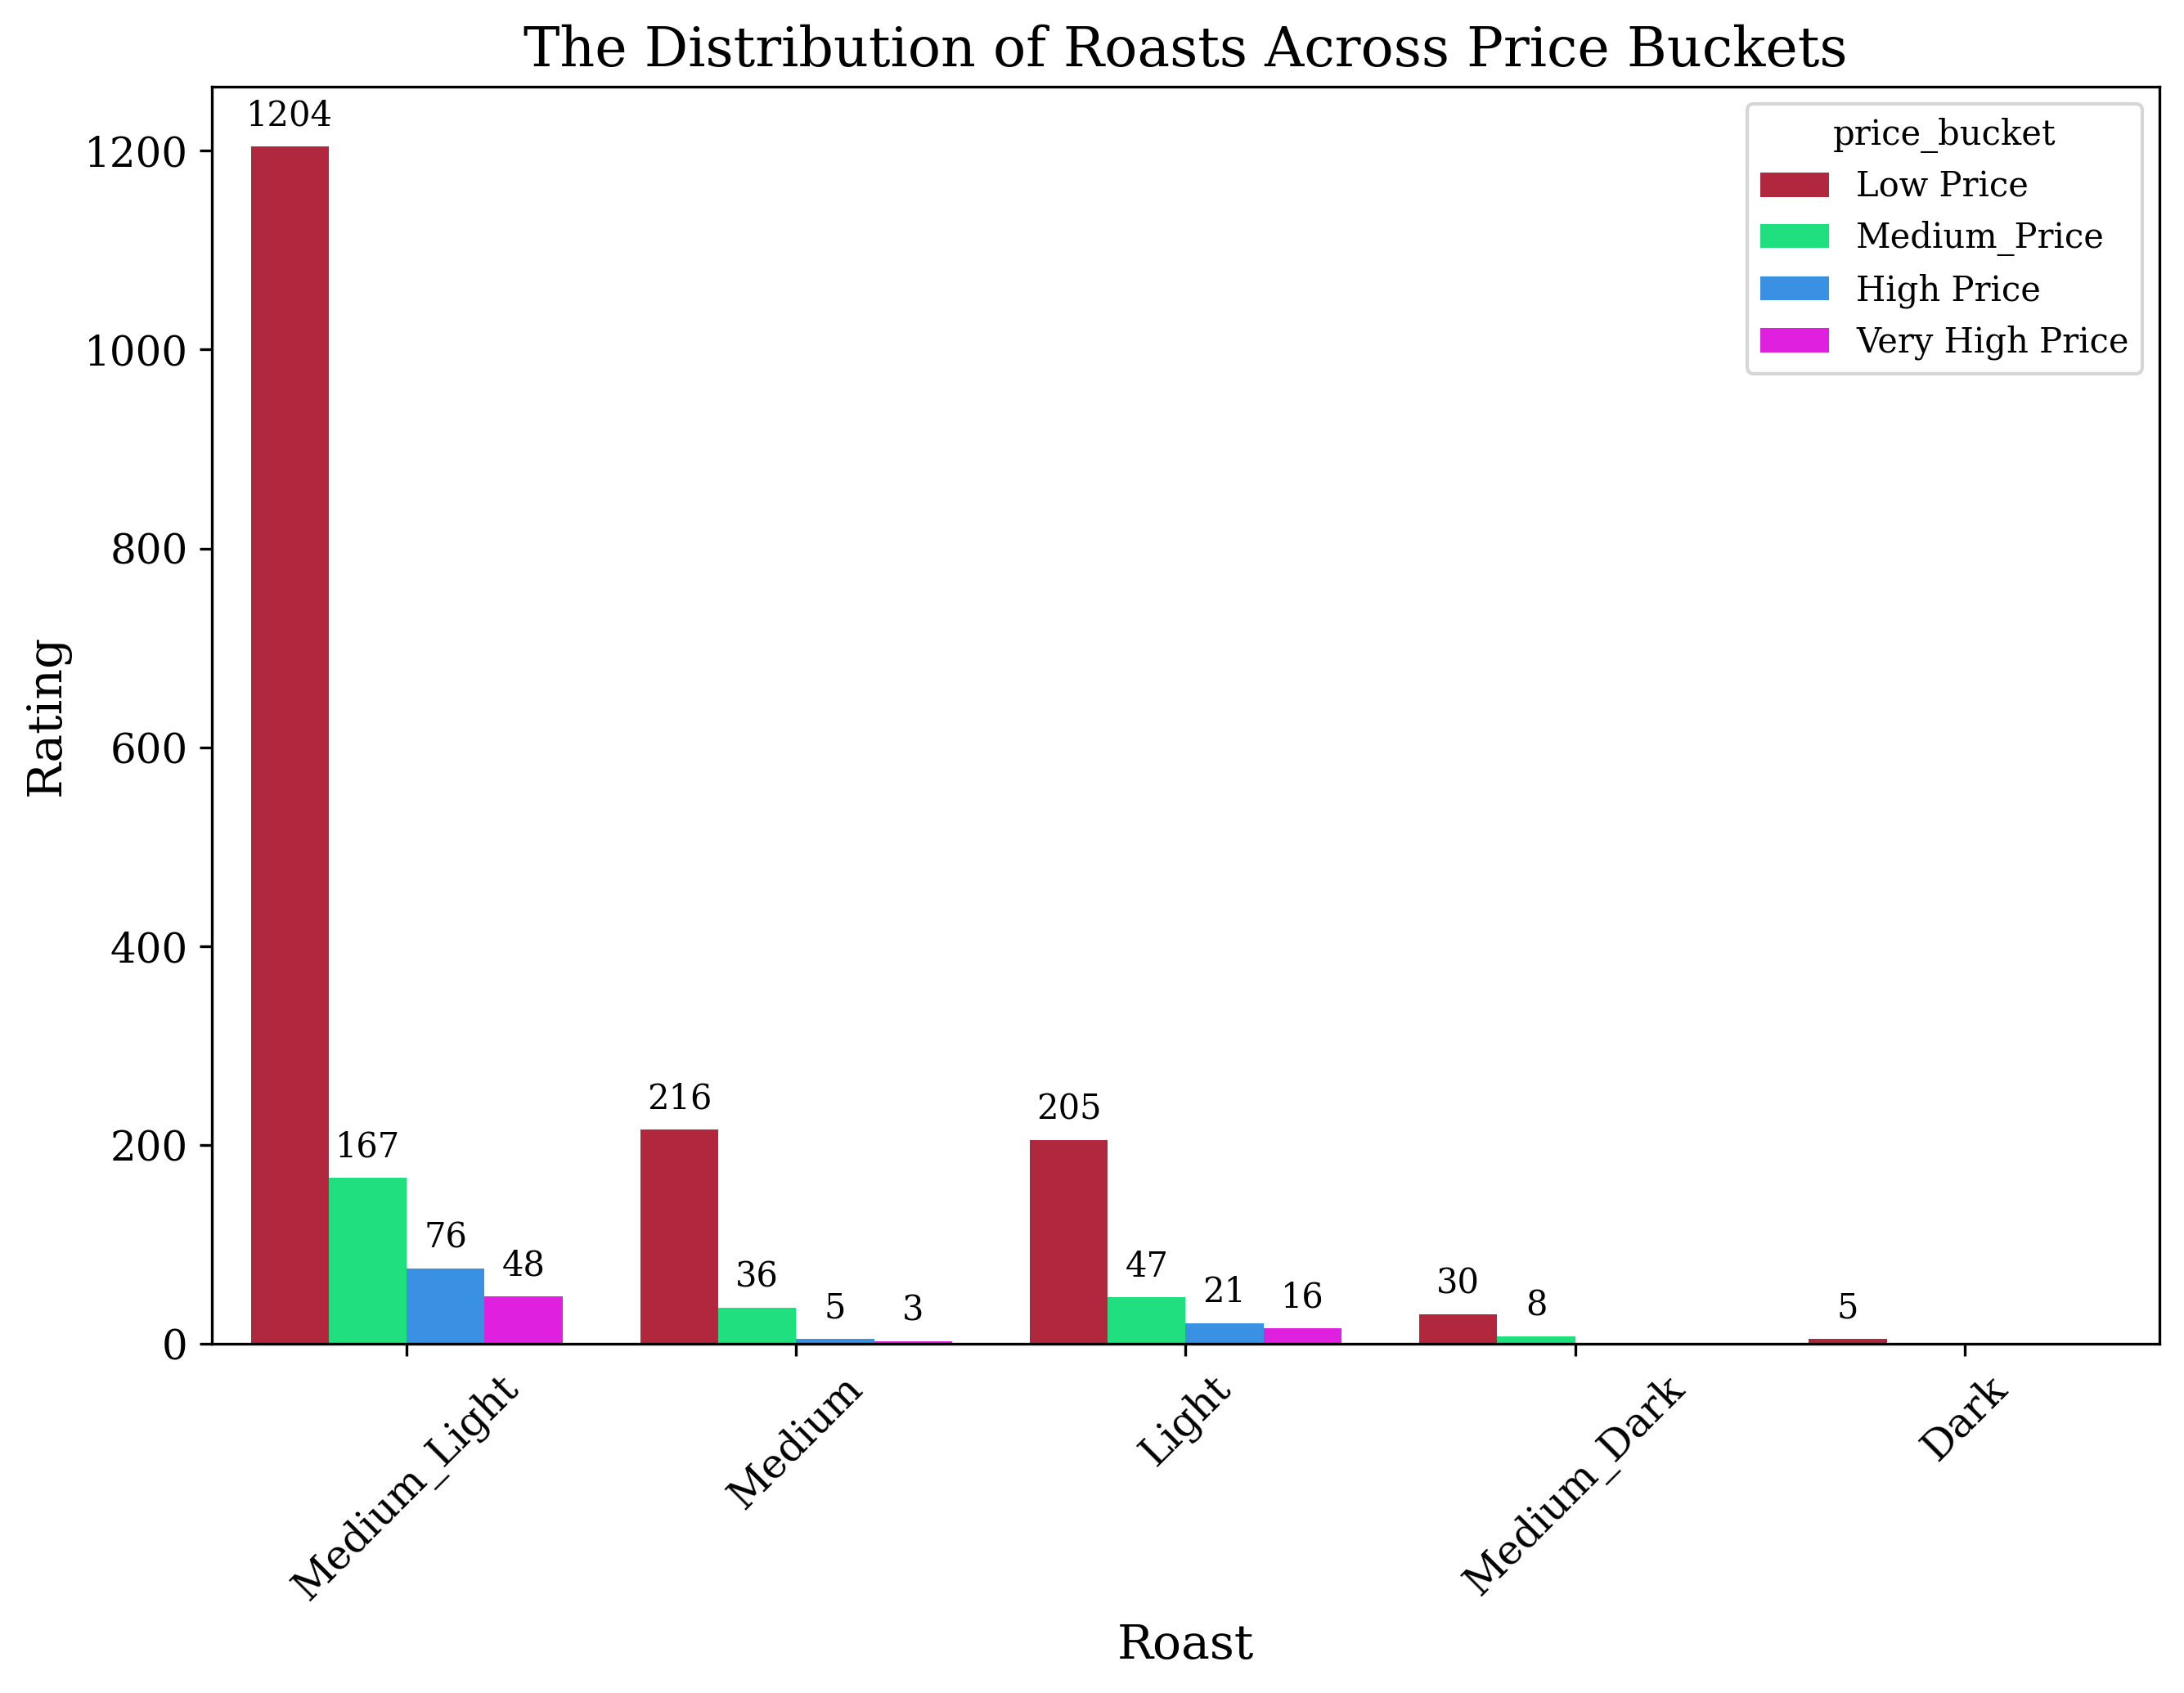

In [ ]:
# Set the default font to serif; it looks better than the standard sans-serif we see anywhere!
plt.rcParams['font.family'] = 'serif'

# Set the figure size & dots per inch to make the chart look sharp!
plt.figure(figsize = (9, 7), dpi = 300)

# Create a bar plot that shows the average rating for each price bucket.
ax = sns.countplot(data = vader_copy, x = 'roast', hue = 'price_bucket', palette = custom_palette)

# Annotate the bars with the sample count for each roast-price bucket combination.
for p in ax.patches:
  if p.get_height() > 0:
    ax.annotate(format(p.get_height(), '.0f'),
                (p.get_x() + p.get_width()/2., p.get_height()),
                ha = 'center', va = 'center',
                xytext = (0,9),
                textcoords = 'offset points')

# Set the title & labels, and adjust the x-axis's ticks to make the chart more readable.
plt.title('The Distribution of Roasts Across Price Buckets', fontsize = 16)
plt.xlabel('Roast', fontsize = 14)
plt.ylabel('Rating', fontsize = 14)
plt.xticks(rotation = 45, fontsize = 12)
plt.yticks(fontsize = 12)

# Set the layout so that the chart fits within the figure size we defined and then show the chart.
plt.tight_layout()
plt.show()

<ipython-input-68-cad0599562d0>:8: UserWarning: The palette list has more values (5) than needed (3), which may not be intended.
  ax = sns.countplot(data = vader_copy, x = 'roast', hue = 'sentiment_bucket', palette = custom_palette)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tup

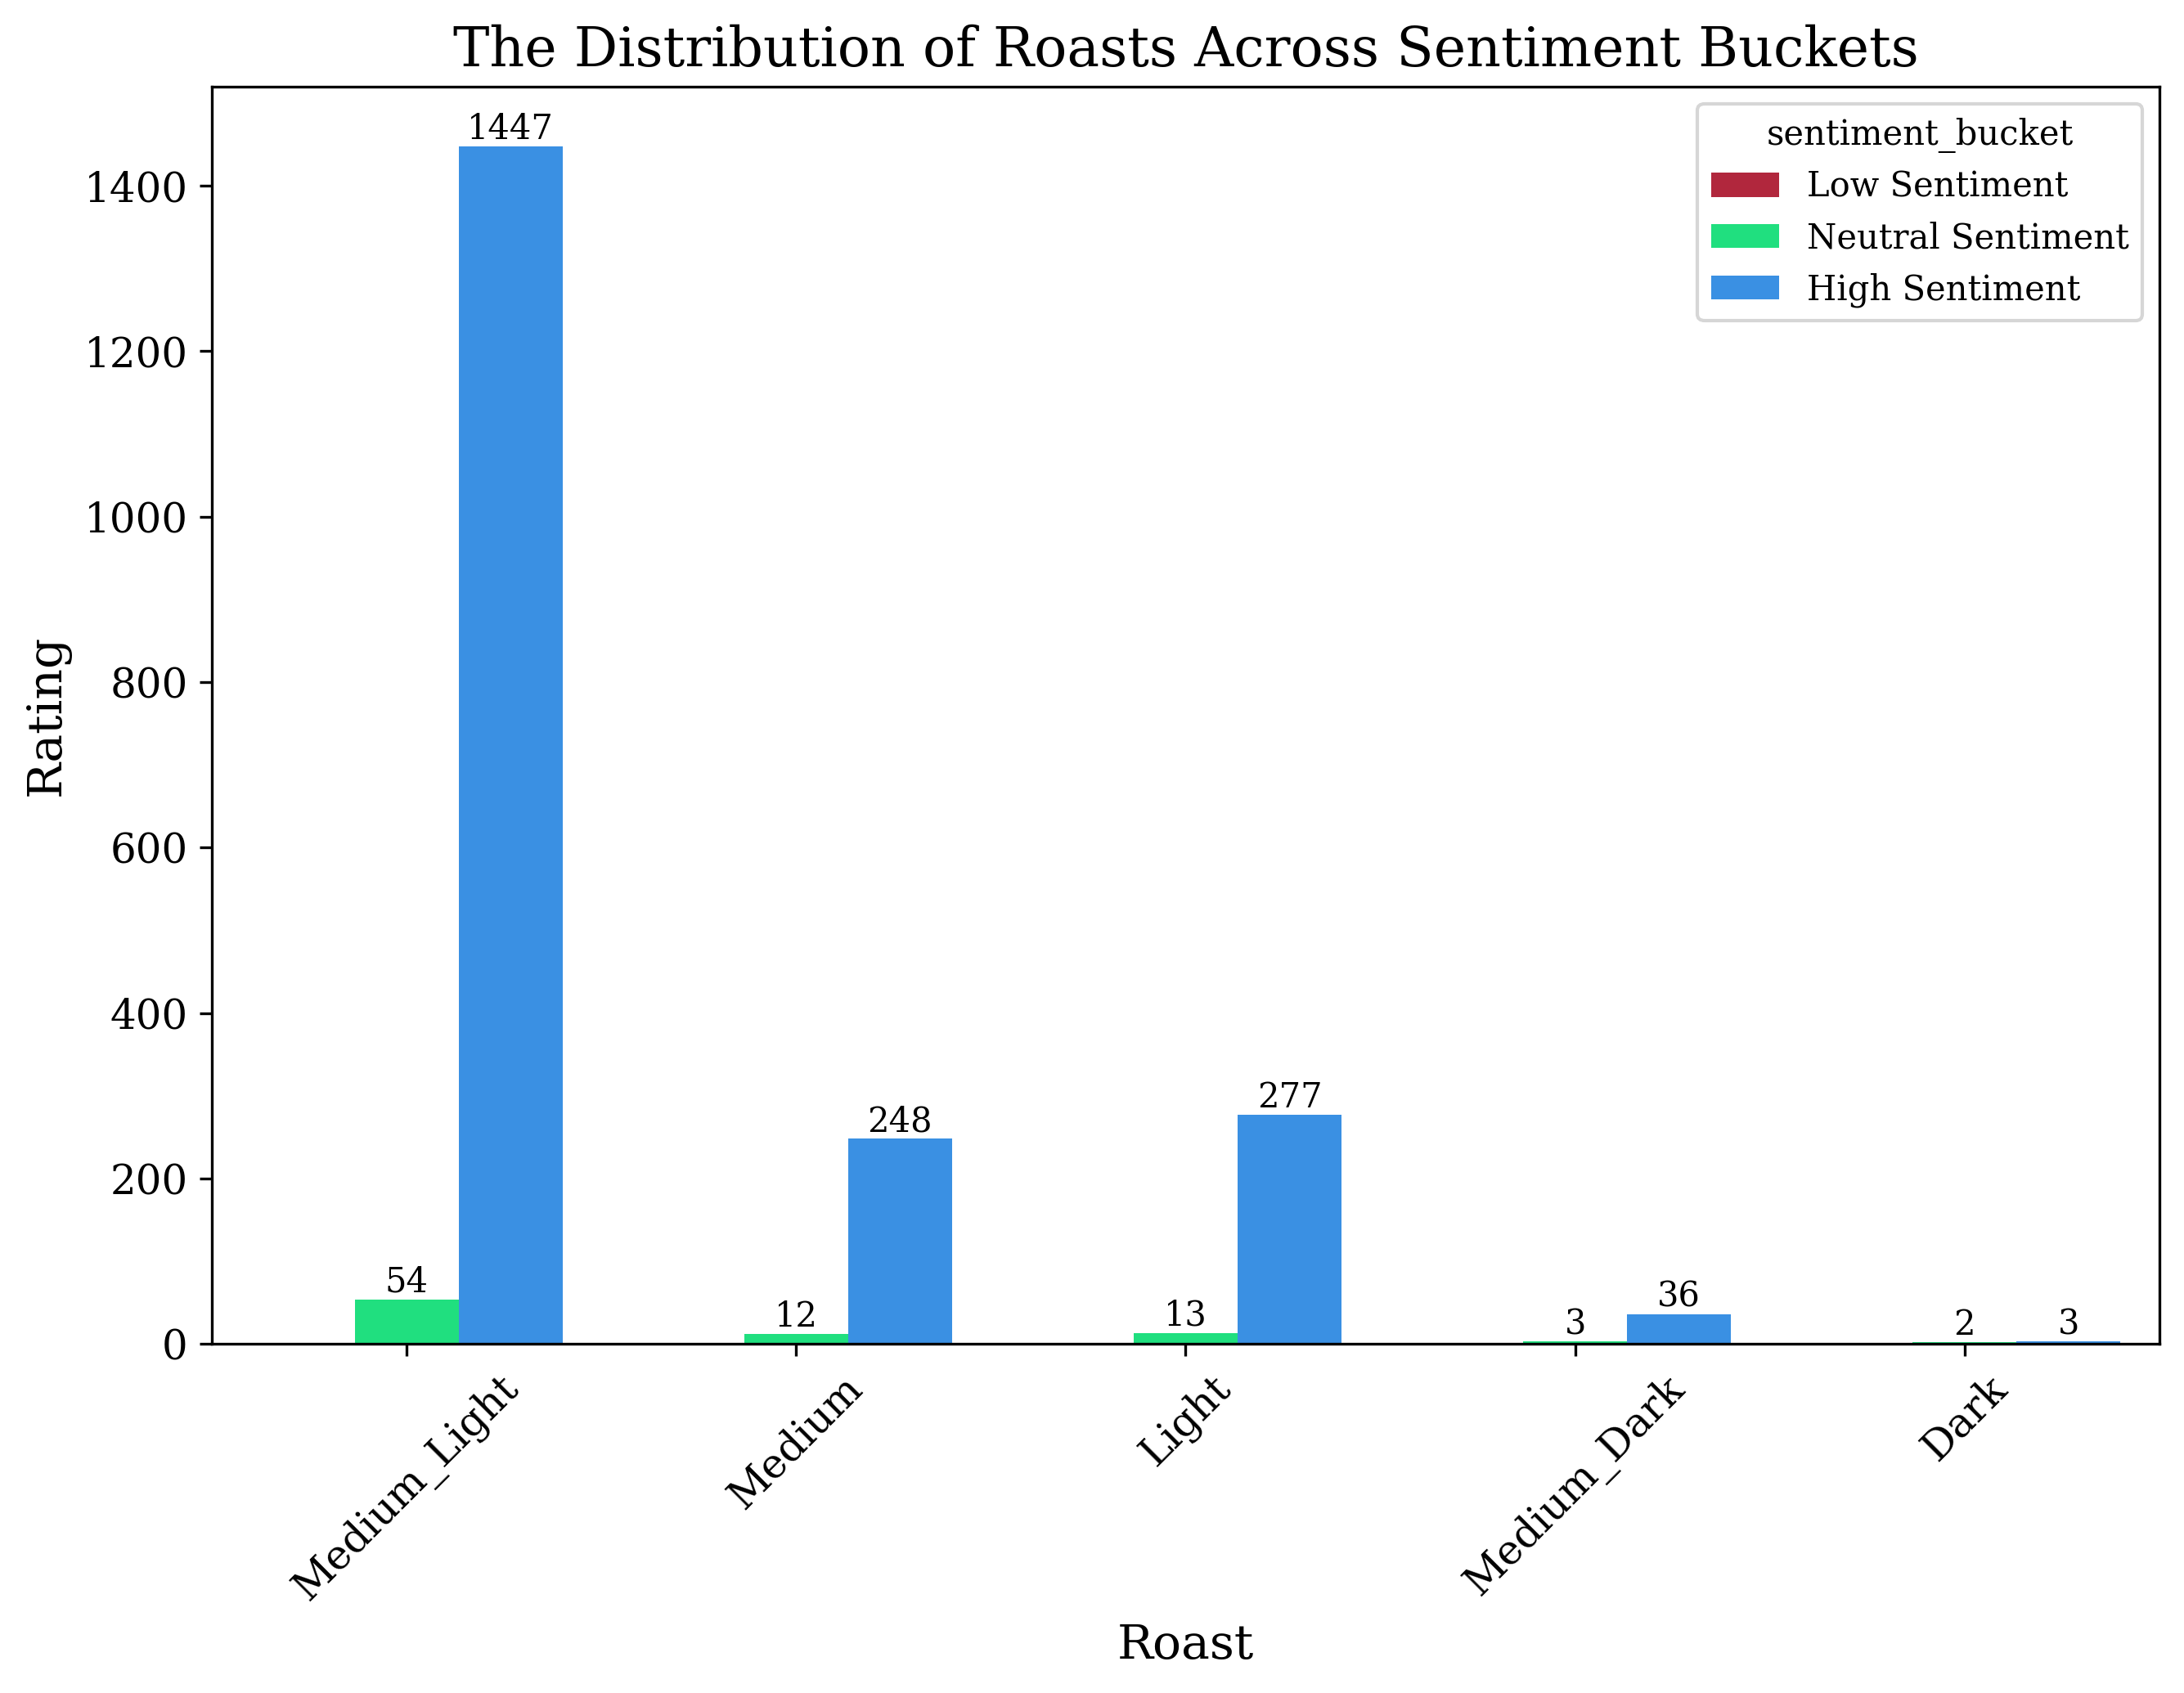

In [ ]:
# Set the default font to serif; it looks better than the standard sans-serif we see anywhere!
plt.rcParams['font.family'] = 'serif'

# Set the figure size & dots per inch to make the chart look sharp!
plt.figure(figsize = (9, 7), dpi = 300)

# Create a count plot that shows the distribution of roasts across the sentiment buckets.
ax = sns.countplot(data = vader_copy, x = 'roast', hue = 'sentiment_bucket', palette = custom_palette)

# Annotate the bars with the sample count for each roast-sentiment bucket combination.
for p in ax.patches:
  height = p.get_height()
  if height > 0:
    ax.text(p.get_x() + p.get_width()/2, height + 0.1, f'{height:.0f}',
    ha = 'center', va = 'bottom', fontsize = 10)

# Set the title & labels, and adjust the x-axis's ticks to make the chart more readable.
plt.title('The Distribution of Roasts Across Sentiment Buckets', fontsize = 16)
plt.xlabel('Roast', fontsize = 14)
plt.ylabel('Rating', fontsize = 14)
plt.xticks(rotation = 45, fontsize = 12)
plt.yticks(fontsize = 12)

# Set the layout so that the chart fits within the figure size we defined and then show the chart.
plt.tight_layout()
plt.show()

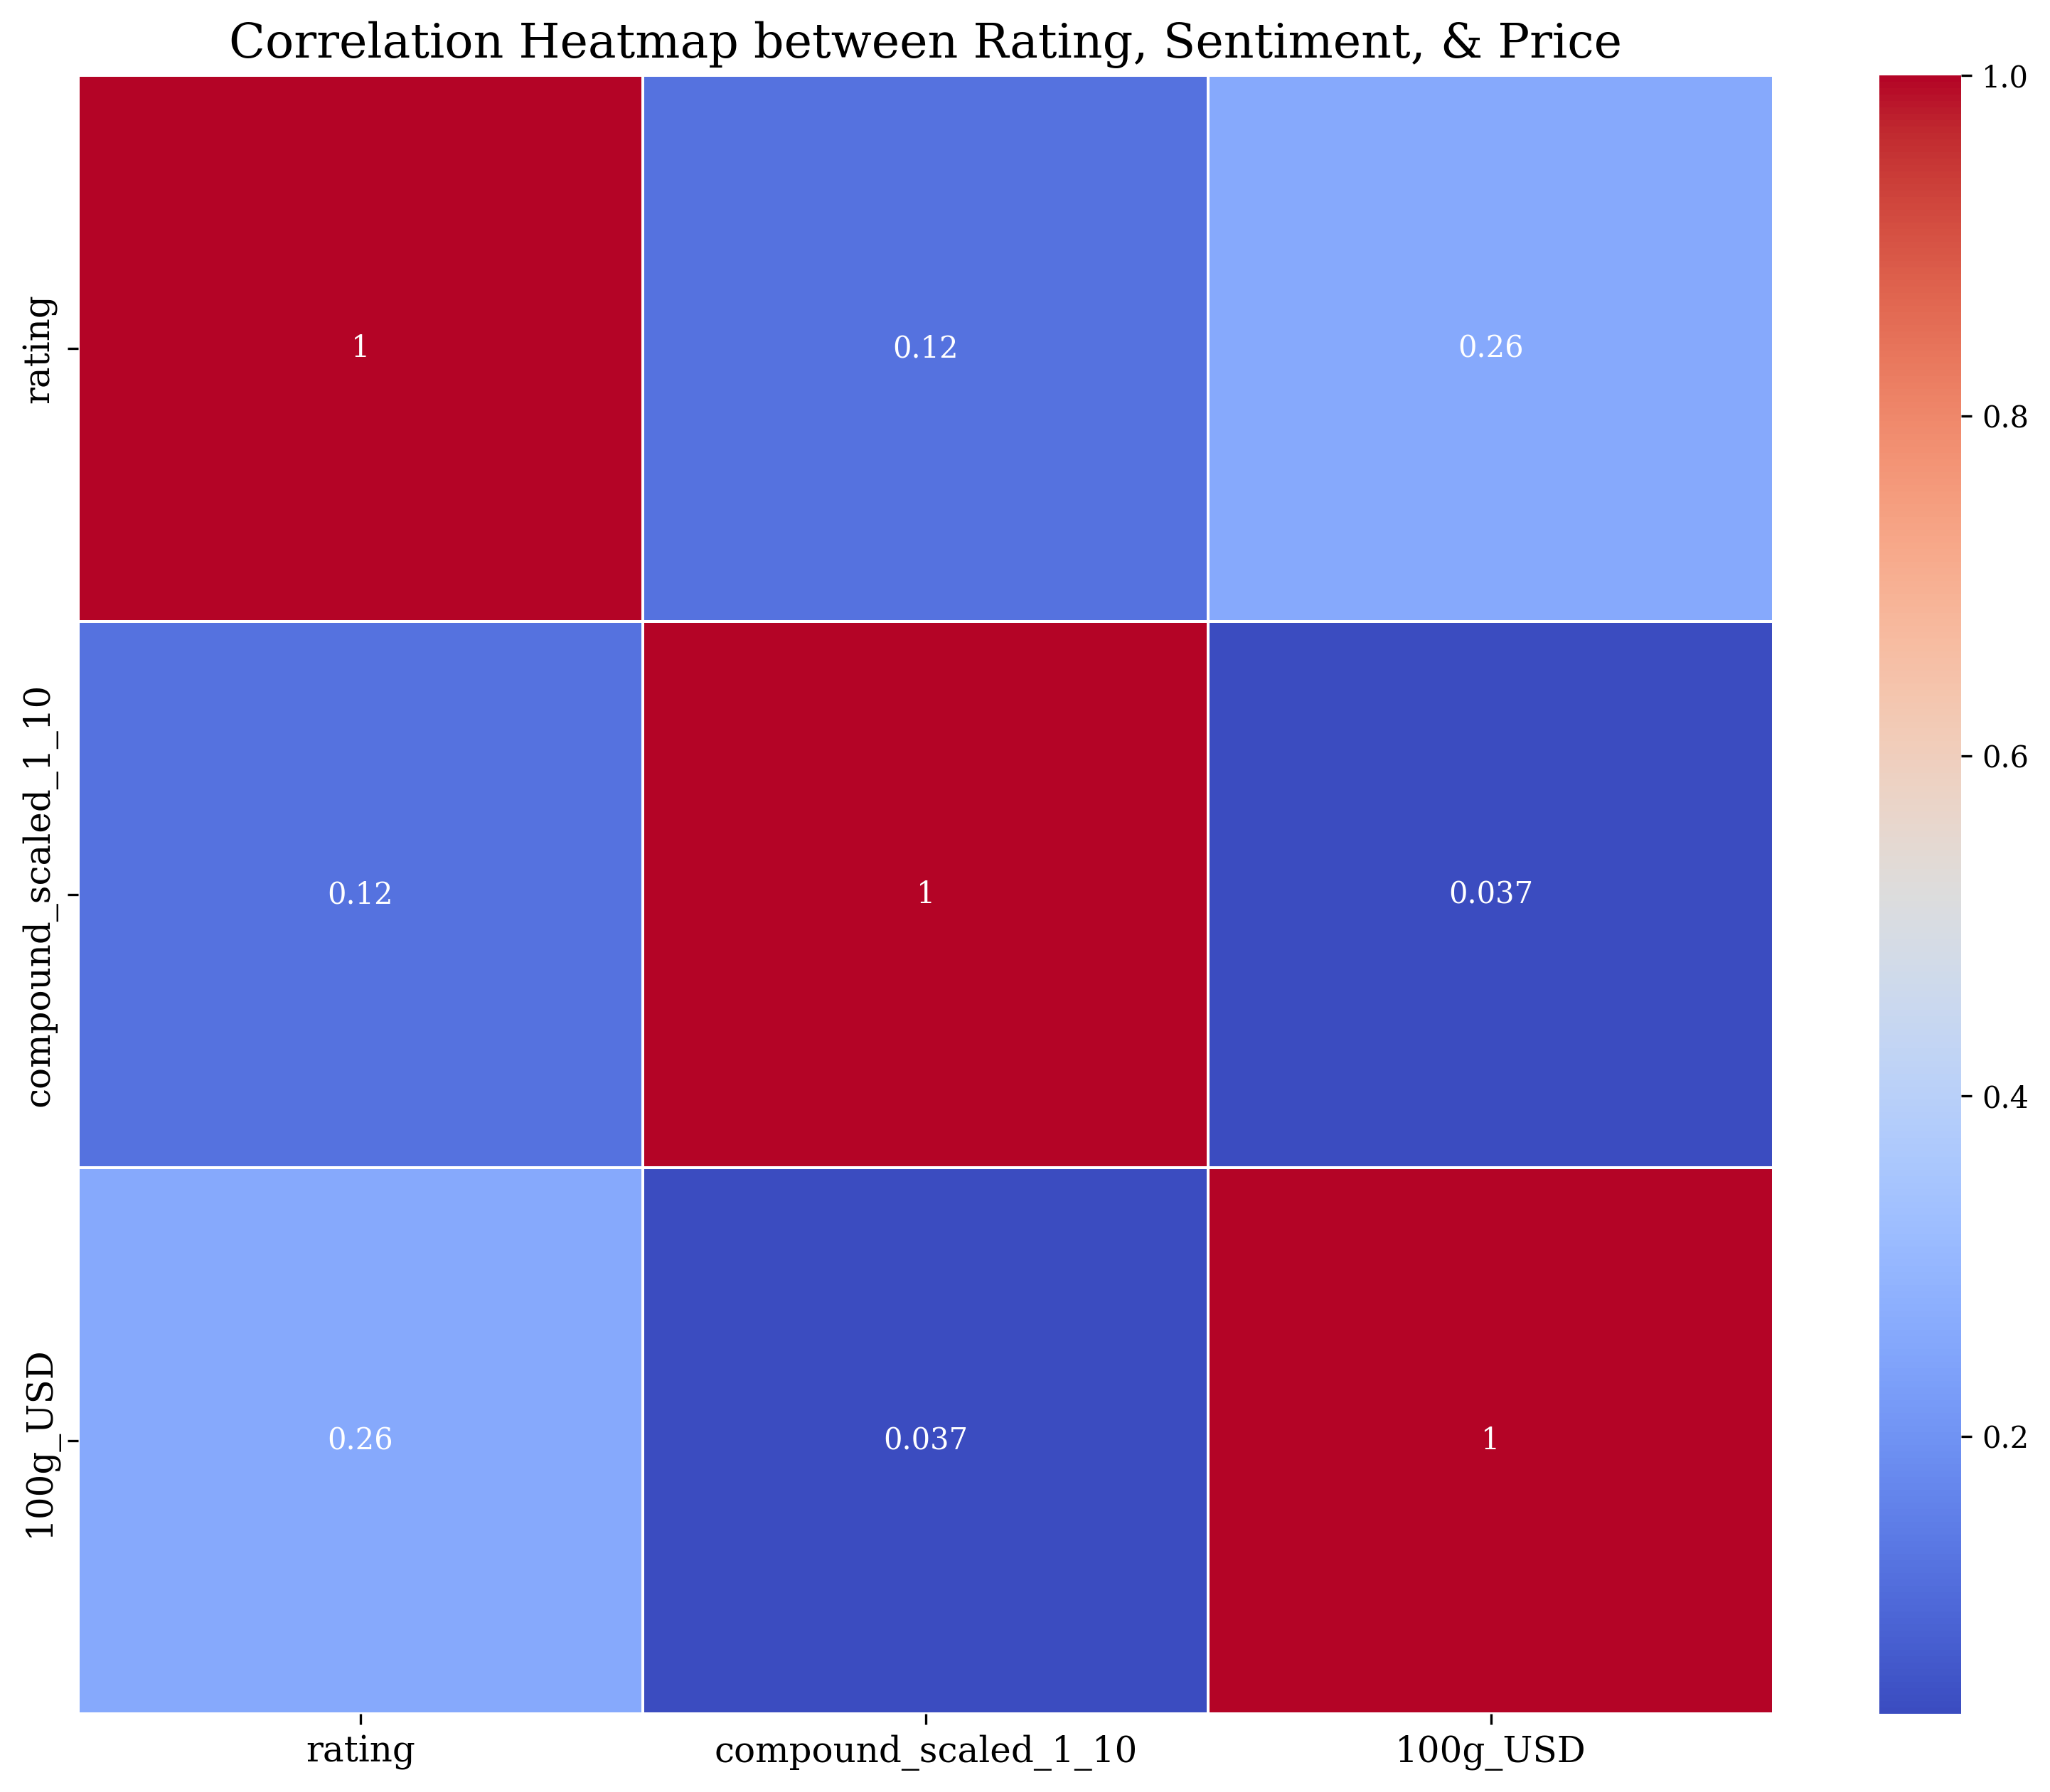

In [ ]:
# Create a correlation matrix between the rating, sentiment scores, & the price.
corr = vader_copy[['rating', 'compound_scaled_1_10', '100g_USD']].corr()

# Set the figure size & dots per inch to make the chart look sharp!
plt.figure(figsize = (10.5, 8.5), dpi = 300)

# Plot a heatmap to show the correlations we calculated above.
sns.heatmap(corr, annot = True, cmap = 'coolwarm', linewidth = 0.5)

# Set the title & labels, and adjust the font size to make the chart more readable.
plt.title('Correlation Heatmap between Rating, Sentiment, & Price', fontsize = 16)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

# Set the layout so that the chart fits within the figure size we defined and then show the chart.
plt.tight_layout()
plt.show()

In [ ]:
# Get a summary of each roast's rating & sentiment score.

roast_summary = vader_copy.groupby('roast')[['rating', 'compound_scaled_1_10']].mean()
print("Roast Summary:")
roast_summary

Roast Summary:


,rating,compound_scaled_1_10
roast,,
Dark,88.200000,7.523650
Light,93.513793,8.930061
Medium,92.280769,8.807495
Medium_Dark,91.871795,8.410231
Medium_Light,93.229847,8.883425


## **Text Cleaning, Word Vectorization, PCA & Further Preprocessing for Model Fitting & Analysis**

In [ ]:
# Create a clean text function, and then apply it to the name, roaster, roast, loc_county, origin_1, & origin_2 columns.

def clean_Text(text):
  text = text.lower()

  text = text.translate(str.maketrans('', '', string.punctuation))

  text = text.replace("“", "").replace("”", "").replace("‘", "").replace("’", "").replace("'", "").replace('"', "")

  return text


columns_to_clean = ['name', 'roaster', 'roast', 'loc_country', 'origin_1', 'origin_2']

for column in columns_to_clean:
  vader_data[column] = vader_data[column].apply(clean_Text)

In [ ]:
# Tokenize the text.
tokenized_text = [desc.split() for desc in vader_data['cleaned_desc_1']]

In [ ]:
# Set up the Word2Vec model
'''
For this project, we're using the Continuous Bag of Words approach to Word2Vec.
The main reason for this is that the coffee reviews are very detailed in terms of how they describe the coffees.
Because of this aspect of the nature of the data, we thought it best to use CBoW instead of Skip-Gram.
'''
word2vec_model = Word2Vec(sentences = tokenized_text, vector_size = 100, window = 5, min_count = 1, workers = 4)

In [ ]:
# Calculate the document vectors by averaging the word vectors.

from itertools import count
def get_Vector(text):
  words = text.split()
  vector = np.zeros(100)
  counter = 0
  for word in words:
    if word in word2vec_model.wv.key_to_index:
      vector += word2vec_model.wv[word]
      counter += 1
    if counter >0:
      vector /= counter
    return vector

# Apply the function to get the document vectors for the reviews.
vader_data['document_vectors'] = vader_data['cleaned_desc_1'].apply(get_Vector)

In [ ]:
# Convert the document vectors into an array so that we can then apply Principal Component Analysis onto them.

document_vectors = np.array(vader_data['document_vectors'].tolist())

'''
Perform PCA on the vectors to reduce the document vectors' dimensionality further.
When we looked at the dataset, we came to the conclusion that 5 components would be enough for the purposes of reducing the dimensionality.
Creating more components after the fifth one seemed to capture such a small amount of information we thought they wouldn't be needed.
'''
pcs = PCA(n_components = 5)
pca_document_vectors = pcs.fit_transform(document_vectors)

In [ ]:
# Convert the results from PCA into a Pandas Dataframe & concatenate the new dataframe back into the original one.

document_vectors_df = pd.DataFrame(pca_document_vectors, columns = [f'pc_{i+1}' for i in range(5)])
vader_data = pd.concat([vader_data.reset_index(drop = True), document_vectors_df.reset_index(drop = True)], axis = 1)

# Drop the reviews & document vectors column, as Word2Vec & PCA have allowed us to create dense word embeddings that capture the semantic meanings of the rows in the reviews column.
vader_data = vader_data.drop(columns = ['cleaned_desc_1', 'document_vectors'])

In [ ]:
# Convert column names to lowercase to get consistency & ease of reference.
vader_data.columns = vader_data.columns.str.lower().str.replace(' ', '_').str.replace('-', '_')

# Remove any characters from column names that aren't letters, numbers, or underscores.
vader_data.columns = vader_data.columns.str.replace(r'[^a-aA-z0-9_]', '', regex = True)

In [ ]:
# Apply label encoding to the categorical columns.
label_columns = ['name', 'roaster', 'roast', 'loc_country', 'origin_1', 'origin_2']
label_encoder = LabelEncoder()

for column in label_columns:
  vader_data[column] = label_encoder.fit_transform(vader_data[column])

In [ ]:
# Apply standard scaling to numerical features.
scaler = StandardScaler()

numerical_features = ['rating', 'compound_scaled_1_10', 'pc_1', 'pc_2', 'pc_3', 'pc_4', 'pc_5']
vader_data[numerical_features] = scaler.fit_transform(vader_data[numerical_features])

In [ ]:
# Define X as the feature matrix, and y as the target variable.

X = vader_data[['compound_scaled_1_10', 'rating', 'roaster', 'origin_1', 'origin_2', 'pc_1', 'pc_2', 'pc_3', 'pc_4', 'pc_5', 'review_year', 'review_month', 'review_day']]
y = vader_data['100g_usd']

In [ ]:
# Copy the dataset into vader_data_encoded to further preprocess the categorical columns.

vader_data_encoded = vader_data.copy()

# Define the categorical columns, and then apply label encoding to them.
categorical_columns = ['price_bucket', 'sentiment_bucket', 'roaster', 'origin_1', 'origin_2', 'name', 'roast', 'loc_country', 'rating_bucket']

label_encoder = LabelEncoder()

for column in categorical_columns:
  vader_data_encoded[column] = label_encoder.fit_transform(vader_data_encoded[column].astype(str))

In [ ]:
# Establish X_encoded as the feature matrix, & y_encoded as the target variable.

X_encoded = vader_data_encoded.drop(columns = ['price_bucket', '100g_usd'])
y_encoded = vader_data_encoded['price_bucket']

In [ ]:
'''
As we saw earlier, there's an inherent imbalance in the dataset towards reviews being positive leaning. So if we just ran ML models on the data, it wouldn't give us accurate results.
So we're using SMOTE, or Synthetic Minority Over-sampling TEchnique to over-sample the minority class of the dataset, so that when we run ML models on the data, we get better results.
'''

smote = SMOTE(random_state = 42)
X_resampled, y_resampled = smote.fit_resample(X_encoded,y_encoded)

In [ ]:
# Split the now-resampled data into a 70-30 split between training & testing sets.

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size = 0.3, random_state = 42)

In [ ]:
# Take a quick look at the training data's distribution for price_buckets.

print("The Training Data's Original Price Distribution:")
y_train.value_counts()

The Training Data's Original Price Distribution:


,count
price_bucket,
3,1175
4,1170
2,1165
0,1156
1,1144


## **Model Fitting & Predictions**

In [ ]:
# Set up a Random Forest Classifier model, and fit it to the training data.

rfc_Model = RandomForestClassifier(n_estimators = 150, max_depth = 10, min_samples_split = 10, min_samples_leaf = 5, bootstrap = True, random_state = 42)
rfc_Model.fit(X_train, y_train)

RandomForestClassifier(max_depth=10, min_samples_leaf=5, min_samples_split=10,
                       n_estimators=150, random_state=42)

In [ ]:
# Make predictions on the testing data.

y_Pred_RFC = rfc_Model.predict(X_test)
rfc_Accuracy = accuracy_score(y_test, y_Pred_RFC)
print(f"Random Forest Classifier Accuracy: {(rfc_Accuracy*100):.2f}%")
print(f"Random Forest Classifier Classification Report: \n {classification_report(y_test, y_Pred_RFC)}")

Random Forest Classifier Accuracy: 91.53%
Random Forest Classifier Classification Report: 
               precision    recall  f1-score   support

           0       0.91      0.93      0.92       504
           1       0.87      0.90      0.89       516
           2       0.89      0.84      0.86       495
           3       0.92      0.91      0.92       485
           4       0.99      1.00      0.99       490

    accuracy                           0.92      2490
   macro avg       0.92      0.92      0.92      2490
weighted avg       0.92      0.92      0.91      2490



In [ ]:
'''
We want to ensure that the model's accuracy isn't a result of overfitting to the data.
So let's run K-fold cross-validation with 5 folds to let the model get a better idea of the dataset, and get the cross-validated accuracy.
The cross-validated accuracy being close to the model's initial accuracy tells us it's performing well while not overfitting!
'''

cv_Scores_RFC = cross_val_score(rfc_Model, X_train, y_train, cv = 5, scoring = 'accuracy')
print(f"Random Forest Classifier — Cross-Validation Accuracy Scores: {cv_Scores_RFC}")
print(f"Random Forest Classifier — Average Cross-Validation Accuracy: {(cv_Scores_RFC.mean()*100):.2f}%")

Random Forest Classifier — Cross-Validation Accuracy Scores: [0.89845095 0.91222031 0.90361446 0.89931153 0.92254733]
Random Forest Classifier — Average Cross-Validation Accuracy: 90.72%


In [ ]:
# Set up a K-Nearest Neighbors Classifier model, and fit it to the training data.

knn_Model = KNeighborsClassifier(n_neighbors = 4, weights = 'distance', algorithm = 'brute', leaf_size = 20, p = 2, metric = 'minkowski')
knn_Model.fit(X_train, y_train)

KNeighborsClassifier(algorithm='brute', leaf_size=20, n_neighbors=4,
                     weights='distance')

In [ ]:
# Make predictions on the testing data.

y_Pred_KNN = knn_Model.predict(X_test)
knn_Accuracy = accuracy_score(y_test, y_Pred_KNN)
print(f"K-Nearest Neighbors Classifier Accuracy: {(knn_Accuracy*100):.2f}%")
print(f"K-Nearest Neighbors Classifier Classification Report: \n {classification_report(y_test, y_Pred_KNN)}")

K-Nearest Neighbors Classifier Accuracy: 87.23%
K-Nearest Neighbors Classifier Classification Report: 
               precision    recall  f1-score   support

           0       0.85      0.93      0.89       504
           1       0.93      0.66      0.77       516
           2       0.80      0.88      0.84       495
           3       0.84      0.91      0.87       485
           4       0.97      0.99      0.98       490

    accuracy                           0.87      2490
   macro avg       0.88      0.87      0.87      2490
weighted avg       0.88      0.87      0.87      2490



In [ ]:
'''
We want to ensure that the model's accuracy isn't a result of overfitting to the data.
So let's run K-fold cross-validation with 5 folds to let the model get a better idea of the dataset, and get the cross-validated accuracy.
The cross-validated accuracy being close to the model's initial accuracy tells us it's performing well while not overfitting!
'''

cv_Scores_KNN = cross_val_score(knn_Model, X_train, y_train, cv = 5, scoring = 'accuracy')
print(f"K-Nearest Neighbors Classifier — Cross-Validation Accuracy Scores: {cv_Scores_KNN}")
print(f"K-Nearest Neighbors Classifier — Average Cross-Validation Accuracy: {(cv_Scores_KNN.mean()*100):.2f}%")

K-Nearest Neighbors Classifier — Cross-Validation Accuracy Scores: [0.85886403 0.87693632 0.85283993 0.86230637 0.84251291]
K-Nearest Neighbors Classifier — Average Cross-Validation Accuracy: 85.87%


In [ ]:
# Set up a Random Forest Classifier model, and fit it to the training data.

xgb_Model = XGBClassifier(n_estimators = 150, learning_rate = 0.1, max_depth = 5, min_child_weight = 3, gamma = 0.1, subsample = 0.7, colsample_bytree = 0.7)
xgb_Model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=0.1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=3, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=150, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [ ]:
y_Pred_XGB = xgb_Model.predict(X_test)

xgb_Accuracy = accuracy_score(y_test, y_Pred_XGB)
print(f"XGBost Accuracy: {(xgb_Accuracy * 100):.2f}%.")
print(f"Xtreme Gradient Boosting Tree Classifier Classification Report: \n {classification_report(y_test, y_Pred_XGB)}")

XGBost Accuracy: 94.98%.
Xtreme Gradient Boosting Tree Classifier Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.96      0.96       504
           1       0.92      0.95      0.93       516
           2       0.92      0.90      0.91       495
           3       0.96      0.95      0.95       485
           4       0.99      1.00      0.99       490

    accuracy                           0.95      2490
   macro avg       0.95      0.95      0.95      2490
weighted avg       0.95      0.95      0.95      2490



In [ ]:
'''
We want to ensure that the model's accuracy isn't a result of overfitting to the data.
So let's run K-fold cross-validation with 5 folds to let the model get a better idea of the dataset, and get the cross-validated accuracy.
The cross-validated accuracy being close to the model's initial accuracy tells us it's performing well while not overfitting!
'''

cv_Scores_XGB = cross_val_score(xgb_Model, X_train, y_train, cv = 5, scoring = 'accuracy')
print(f"X-Treme Gradient Boosting Classifier Cross-Validation Accuracy Scores: {cv_Scores_XGB}")
print(f"X-Treme Gradient Boosting Classifier Average Cross-Validation Accuracy: {(cv_Scores_XGB.mean()*100):.2f}%")

X-Treme Gradient Boosting Classifier Cross-Validation Accuracy Scores: [0.93717728 0.94492255 0.94320138 0.95008606 0.93373494]
X-Treme Gradient Boosting Classifier Average Cross-Validation Accuracy: 94.18%


In [ ]:
kakalove_cafe_avg_price = vader_copy[vader_copy['roaster'] == 'Kakalove Cafe']['100g_USD'].mean()
print(f'${kakalove_cafe_avg_price:.2f}')

$6.52
